In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import models

import pandas as pd
import numpy as np
import os
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from nltk.corpus import stopwords
import re
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.models import Model
from keras.utils import np_utils
from time import time

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
english_stopwords = set(stopwords.words('english'))
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
parties = tweetsdf['Party']

In [5]:
def tokenize_tweet(s):
    s = s.lower()
    s = re.sub(r'https?://[^\s]+', '', s)
    s = re.sub(r'[^A-Za-z\s$#@0-9]+', '', s)
    s = re.sub(r'\s+', ' ', s)
    return [tok for tok in s.strip().split(' ') if tok not in english_stopwords]
    
tokenized_tweets = [tokenize_tweet(tweet) for tweet in raw_tweets]

vocab = {}
for toks in tokenized_tweets:
    for tok in toks:
        if tok in vocab:
            vocab[tok] += 1
        else:
            vocab[tok] = 1
            
vocab = {k:v for k,v in vocab.items() if v > 10}

vocabulary = list(vocab.keys())
vocabulary_size = len(vocabulary) + 1

word_to_int = {word: i + 1 for i, word in enumerate(vocabulary)}
int_to_word = {i + 1: word for i, word in enumerate(vocabulary)}

In [6]:
encoded_tweets =\
    [[word_to_int.get(tok, 0) for tok in toks if tok in word_to_int]
     for toks in tokenized_tweets]

max_tweet_len = max([len(encoded_tweet) for encoded_tweet in encoded_tweets])

X = []
for encoded_tweet in encoded_tweets:
    v = np.zeros(max_tweet_len)
    v[0:len(encoded_tweet)] = encoded_tweet
    X.append(v)
    
X = np.array(X)

y = 1.0 - np.asarray(parties == 'Democrat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print('Max tweet length: %s' % max_tweet_len)
len(word_to_int)

Max tweet length: 28


8736

In [8]:
def model8(vocabulary_size, max_tweet_len):
    input_layer = Input(shape=(max_tweet_len,))
    x = Embedding(output_dim=100, input_dim=vocabulary_size, input_length=max_tweet_len)(input_layer)
    x = Conv1D(128, kernel_size=4, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input_layer, x)
    optimizer = Adam(lr=0.0003)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return 'word-embedding2.hdf5', model

In [9]:
filepath, model = model8(vocabulary_size, max_tweet_len)
if filepath in os.listdir():
    model.load_weights(filepath)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 28, 100)           873700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           51328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)    

In [10]:
# models.train(X_train, y_train, model, filepath)

In [11]:
predictions = np.argmax(model.predict(X_test), axis=1)

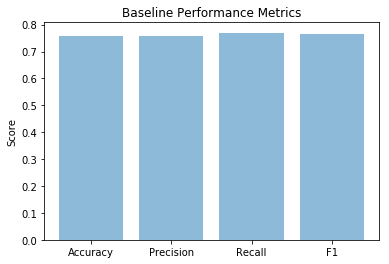

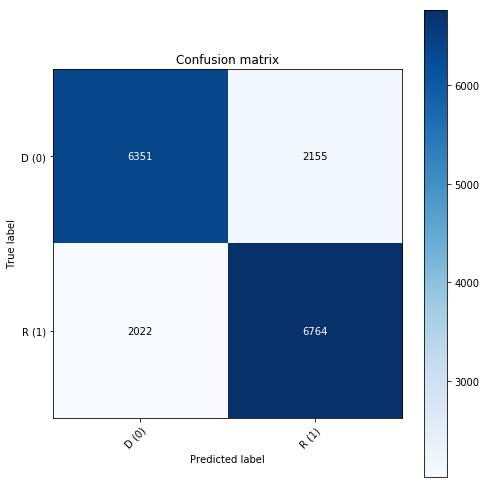

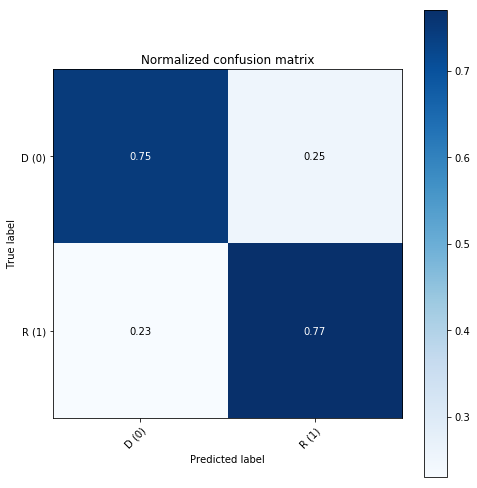

Accuracy: 0.758443210733287
Precision: 0.7583809844152932
Recall: 0.7698611427270657
F1: 0.7640779440835921


In [12]:
metrics, confusion_matrix = models.plot_results(y_test, predictions)
(accuracy, precision, recall, f1) = metrics
print('Accuracy: %s' % accuracy)
print('Precision: %s' % precision)
print('Recall: %s' % recall)
print('F1: %s' % f1)

In [13]:
metrics

[0.758443210733287, 0.7583809844152932, 0.7698611427270657, 0.7640779440835921]

In [14]:
right = []
wrong = []
for i, (actual, pred) in enumerate(zip(y_test, predictions)):
    encoded = X_test[i]
    decoded = ' '.join([int_to_word[int(v)] for v in encoded if v > 0])
    if actual == pred:
        right.append(decoded)
    else:
        wrong.append(decoded)

In [15]:
len([s for s in right if '@' in s])/len(right)

0.3588257720167747

In [16]:
len([s for s in wrong if '@' in s])/len(wrong)

0.17093607852525736

In [18]:
len(vocabulary)

8736